In [22]:
import glob
import os
import re
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from tqdm import tqdm  
from datasets import Dataset, concatenate_datasets, load_dataset

# linear regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

In [54]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100000)
pd.set_option('display.max_colwidth', None)  

In [63]:
subj = pd.read_csv("/nas/ucb/shivamsinghal/preference-learning-with-bounded-cognition/scalable_oversight/data_collection/truthful_qa/LIE_dataset_train.csv")

In [64]:
checkpts = glob.glob("/nas/ucb/shivamsinghal/preference-learning-with-bounded-cognition/data/trained_rew_models/LIE/full_fine_tune_adamw_hf/fold_*/RAPLTrainer/data_seed-42_seed-42/hf-llama-3-8b-dataset_size_800-batch_size_32-lr_1e-05_cosine_decay-warmup_0-num_epochs_2-weight_scale_0.1-last_checkpoint/for_figure/eval_results_test.jsonl")
checkpts

['/nas/ucb/shivamsinghal/preference-learning-with-bounded-cognition/data/trained_rew_models/LIE/full_fine_tune_adamw_hf/fold_1/RAPLTrainer/data_seed-42_seed-42/hf-llama-3-8b-dataset_size_800-batch_size_32-lr_1e-05_cosine_decay-warmup_0-num_epochs_2-weight_scale_0.1-last_checkpoint/for_figure/eval_results_test.jsonl',
 '/nas/ucb/shivamsinghal/preference-learning-with-bounded-cognition/data/trained_rew_models/LIE/full_fine_tune_adamw_hf/fold_2/RAPLTrainer/data_seed-42_seed-42/hf-llama-3-8b-dataset_size_800-batch_size_32-lr_1e-05_cosine_decay-warmup_0-num_epochs_2-weight_scale_0.1-last_checkpoint/for_figure/eval_results_test.jsonl',
 '/nas/ucb/shivamsinghal/preference-learning-with-bounded-cognition/data/trained_rew_models/LIE/full_fine_tune_adamw_hf/fold_0/RAPLTrainer/data_seed-42_seed-42/hf-llama-3-8b-dataset_size_800-batch_size_32-lr_1e-05_cosine_decay-warmup_0-num_epochs_2-weight_scale_0.1-last_checkpoint/for_figure/eval_results_test.jsonl',
 '/nas/ucb/shivamsinghal/preference-learnin

In [65]:
for i, checkpt in enumerate(checkpts):
    eval = pd.read_json(checkpt, lines=True)
    named_cols = ['reward_output_correct_concise', 'reward_output_correct_detailed', 'reward_output_incorrect_concise', 'reward_output_incorrect_detailed']
    updated_cols = [col + "_" + str(i) for col in named_cols]
    eval[updated_cols] = eval[named_cols]
    eval = eval.drop(named_cols,axis=1)
    
    cols = ['correct_detailed', 'correct_concise', 'incorrect_detailed', 'incorrect_concise']
    subj = pd.merge(eval, subj, on=cols)

In [68]:
subj.columns

Index(['correct_detailed', 'correct_concise', 'incorrect_detailed', 'incorrect_concise', 'reward_output_correct_concise_4', 'reward_output_correct_detailed_4', 'reward_output_incorrect_concise_4', 'reward_output_incorrect_detailed_4', 'reward_output_correct_concise_3', 'reward_output_correct_detailed_3', 'reward_output_incorrect_concise_3', 'reward_output_incorrect_detailed_3', 'reward_output_correct_concise_2', 'reward_output_correct_detailed_2', 'reward_output_incorrect_concise_2', 'reward_output_incorrect_detailed_2', 'reward_output_correct_concise_1', 'reward_output_correct_detailed_1', 'reward_output_incorrect_concise_1', 'reward_output_incorrect_detailed_1', 'reward_output_correct_concise_0', 'reward_output_correct_detailed_0', 'reward_output_incorrect_concise_0', 'reward_output_incorrect_detailed_0', 'categories', 'choice1_type', 'choice2_type', 'correct_statements', 'incorrect_statements', 'IDs', 'tags', 'tag_IDs', 'choice1', 'choice2', 'prompt', 'chosen', 'rejected', 'chosen_t

In [81]:
for col in named_cols:
    subj[col+"_mean"] = subj[[col + "_" + str(i) for i in range(5)]].apply(lambda x: x.str[0]).astype(float).mean(axis=1)

In [90]:
subj.columns

Index(['correct_detailed', 'correct_concise', 'incorrect_detailed', 'incorrect_concise', 'reward_output_correct_concise_4', 'reward_output_correct_detailed_4', 'reward_output_incorrect_concise_4', 'reward_output_incorrect_detailed_4', 'reward_output_correct_concise_3', 'reward_output_correct_detailed_3', 'reward_output_incorrect_concise_3', 'reward_output_incorrect_detailed_3', 'reward_output_correct_concise_2', 'reward_output_correct_detailed_2', 'reward_output_incorrect_concise_2', 'reward_output_incorrect_detailed_2', 'reward_output_correct_concise_1', 'reward_output_correct_detailed_1', 'reward_output_incorrect_concise_1', 'reward_output_incorrect_detailed_1', 'reward_output_correct_concise_0', 'reward_output_correct_detailed_0', 'reward_output_incorrect_concise_0', 'reward_output_incorrect_detailed_0', 'categories', 'choice1_type', 'choice2_type', 'correct_statements', 'incorrect_statements', 'IDs', 'tags', 'tag_IDs', 'choice1', 'choice2', 'prompt', 'chosen', 'rejected', 'chosen_t

In [94]:
subj["correctness_weight"] = (subj["reward_output_correct_detailed_mean"]-subj["reward_output_incorrect_detailed_mean"]) + (subj["reward_output_correct_concise_mean"]-subj["reward_output_incorrect_concise_mean"])/2
subj["length_weight"] = (subj["reward_output_correct_detailed_mean"]-subj["reward_output_correct_concise_mean"]) + (subj["reward_output_incorrect_detailed_mean"]-subj["reward_output_incorrect_concise_mean"])/2
subj["ratio"] = subj["correctness_weight"] / subj["length_weight"]

In [95]:
subj = subj[subj["tags"].isin([1122, 2211])]
subj.shape

(542, 56)

In [96]:
def get_correct_chosen(row):
    if "incorrect" in row["chosen_type"]:
        return 0
    return 1
subj["correct_chosen"] = subj.apply(get_correct_chosen,axis=1)

In [101]:
sample_counts = subj.groupby('categories')['correct_chosen'].count()
min_samples = 40
categories_with_enough_samples = sample_counts[sample_counts >= min_samples].index
filtered_subj = subj[subj['categories'].isin(categories_with_enough_samples)]

In [102]:
accuracy_per_category = filtered_subj.groupby('categories')['correct_chosen'].mean()
accuracy_per_category

categories
Economics         0.245283
Health            0.492754
Law               0.229885
Misconceptions    0.247423
Sociology         0.455882
Name: correct_chosen, dtype: float64

In [103]:
length_per_category = filtered_subj.groupby('categories')['length_weight'].mean()
length_per_category

categories
Economics         1.982527
Health            2.018627
Law               2.073729
Misconceptions    2.022268
Sociology         2.012758
Name: length_weight, dtype: float64

In [104]:
fact_per_category = filtered_subj.groupby('categories')['correctness_weight'].mean()
fact_per_category

categories
Economics         0.215584
Health            0.996458
Law               0.142884
Misconceptions    0.383394
Sociology         0.601304
Name: correctness_weight, dtype: float64

In [105]:
ratio_per_category = filtered_subj.groupby('categories')['ratio'].mean()
ratio_per_category

categories
Economics         0.197388
Health            0.536001
Law               0.105464
Misconceptions    0.226379
Sociology         0.275957
Name: ratio, dtype: float64

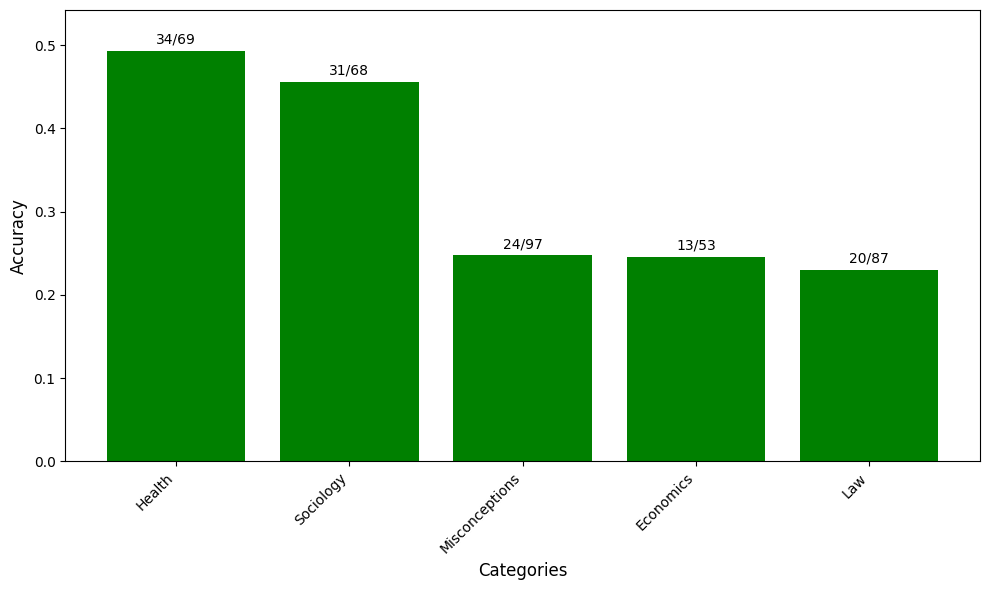

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sample_counts = subj.groupby('categories')['correct_chosen'].count()

min_samples = 30
categories_with_enough_samples = sample_counts[sample_counts >= min_samples].index

filtered_subj = subj[subj['categories'].isin(categories_with_enough_samples)]

accuracy_per_category = filtered_subj.groupby('categories')['correct_chosen'].mean()

correct_counts = filtered_subj.groupby('categories')['correct_chosen'].sum()

sample_counts_filtered = sample_counts.loc[categories_with_enough_samples]

results_df = pd.DataFrame({
    'accuracy': accuracy_per_category,
    'correct': correct_counts,
    'total': sample_counts_filtered
})

results_df = results_df.sort_values(by='accuracy', ascending=False)

categories = results_df.index.tolist()
accuracy_values = results_df['accuracy'].values

plt.figure(figsize=(10, 6))

bars = plt.bar(categories, accuracy_values,
               color="green",)  
               # edgecolor='black',
               # width=0.6)

plt.xlabel('Categories', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)

plt.ylim(0, max(accuracy_values) * 1.1)

# Add data labels on top of each bar (ratio of correct/total)
for bar, correct, total in zip(bars, results_df['correct'], results_df['total']):
    plt.annotate(f'{int(correct)}/{int(total)}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # Vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.savefig("accuracy_per_categories.pdf", format='pdf')

plt.show()



/tmp/ipykernel_778114/1943865709.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.text(i, accuracy_per_category[i] + 0.02,
/tmp/ipykernel_778114/1943865709.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{int(correct_counts[i])}/{counts[i]}',


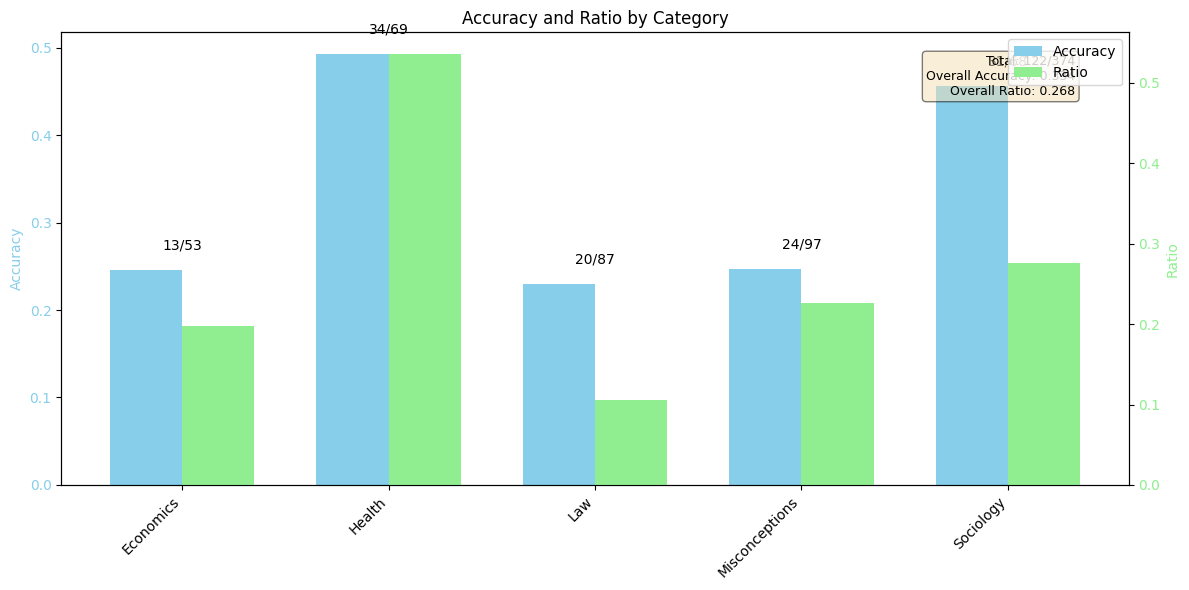

In [108]:
import matplotlib.pyplot as plt

# Set up the figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Get the counts for each category
counts = filtered_subj.groupby('categories').size()
correct_counts = filtered_subj.groupby('categories')['correct_chosen'].sum()

# Set the x positions for the bars
x = np.arange(len(accuracy_per_category))
width = 0.35

# Create the bars
rects1 = ax1.bar(x - width/2, accuracy_per_category, width, label='Accuracy', color='skyblue')
rects2 = ax2.bar(x + width/2, ratio_per_category, width, label='Ratio', color='lightgreen')

# Customize the plots
ax1.set_ylabel('Accuracy', color='skyblue')
ax2.set_ylabel('Ratio', color='lightgreen')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2.tick_params(axis='y', labelcolor='lightgreen')

ax1.set_title('Accuracy and Ratio by Category')
ax1.set_xticks(x)
ax1.set_xticklabels(accuracy_per_category.index, rotation=45, ha='right')

# Add count annotations above bars
for i in range(len(x)):
    ax1.text(i, accuracy_per_category[i] + 0.02, 
            f'{int(correct_counts[i])}/{counts[i]}', 
            ha='center', va='bottom')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add a text box with total statistics
total_correct = int(correct_counts.sum())
total_samples = counts.sum()
total_accuracy = accuracy_per_category.mean()
total_ratio = ratio_per_category.mean()

textstr = f'Total: {total_correct}/{total_samples}\nOverall Accuracy: {total_accuracy:.3f}\nOverall Ratio: {total_ratio:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

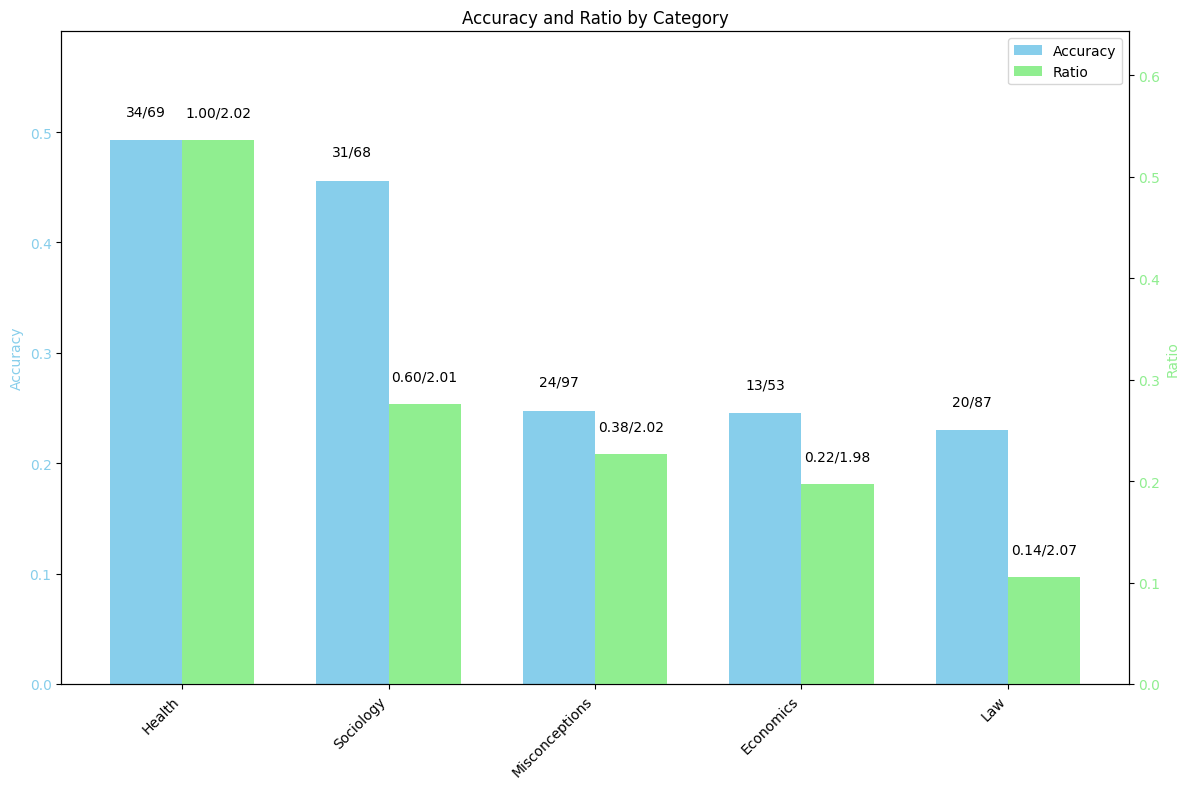

In [119]:
# Sort categories by accuracy
sorted_categories = accuracy_per_category.sort_values(ascending=False).index
weights_per_category = filtered_subj.groupby('categories').agg({
    'correctness_weight': 'mean',
    'length_weight': 'mean'
})

# Set up the figure with two y-axes - made taller and with more bottom margin
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

# Get the counts for each category
counts = filtered_subj.groupby('categories').size()
correct_counts = filtered_subj.groupby('categories')['correct_chosen'].sum()

# Reorder everything by accuracy
accuracy_per_category = accuracy_per_category[sorted_categories]
ratio_per_category = ratio_per_category[sorted_categories]
counts = counts[sorted_categories]
correct_counts = correct_counts[sorted_categories]
weights_per_category = weights_per_category.loc[sorted_categories]

# Set the x positions for the bars
x = np.arange(len(accuracy_per_category))
width = 0.35

# Create the bars
rects1 = ax1.bar(x - width/2, accuracy_per_category, width, label='Accuracy', color='skyblue')
rects2 = ax2.bar(x + width/2, ratio_per_category, width, label='Ratio', color='lightgreen')

# Customize the plots
ax1.set_ylabel('Accuracy', color='skyblue')
ax2.set_ylabel('Ratio', color='lightgreen')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2.tick_params(axis='y', labelcolor='lightgreen')

# Set y-axis limits with some padding
ax1.set_ylim(0, max(accuracy_per_category) * 1.2)  # 20% padding
ax2.set_ylim(0, max(ratio_per_category) * 1.2)     # 20% padding

ax1.set_title('Accuracy and Ratio by Category')
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_categories, rotation=45, ha='right')

# Add count annotations above accuracy bars
for i in range(len(x)):
    ax1.text(i - width/2, accuracy_per_category.iloc[i] + 0.02, 
            f'{int(correct_counts.iloc[i])}/{counts.iloc[i]}', 
            ha='center', va='bottom')
    
    # Add weight ratio annotations above ratio bars
    weight_ratio = f"{weights_per_category['correctness_weight'].iloc[i]:.2f}/{weights_per_category['length_weight'].iloc[i]:.2f}"
    ax2.text(i + width/2, ratio_per_category.iloc[i] + 0.02,
             weight_ratio, ha='center', va='bottom')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout with specific bottom margin for rotated labels
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

In [163]:
plt.rcParams['figure.dpi'] = 300  # High resolution
plt.rcParams['text.usetex'] = True  # Optional: if you want LaTeX rendering


In [165]:
sorted_categories = accuracy_per_category.sort_values(ascending=False).index
weights_per_category = filtered_subj.groupby('categories').agg({
  'correctness_weight': ['mean', 'std'],
  'length_weight': ['mean', 'std']
})

accuracy_std = filtered_subj.groupby('categories')['correct_chosen'].agg(['mean', 'std'])
accuracy_std = accuracy_std.reindex(sorted_categories)

weights_per_category_sem = filtered_subj.groupby('categories').agg({
   'correctness_weight': lambda x: x.std() / np.sqrt(len(x)),
   'length_weight': lambda x: x.std() / np.sqrt(len(x))
})
accuracy_sem = filtered_subj.groupby('categories')['correct_chosen'].agg(
   lambda x: x.std() / np.sqrt(len(x)))

fig, ax1 = plt.subplots(figsize=(1.75, 2))  # Width=1.75 inches
ax2 = ax1.twinx()

accuracy_per_category = accuracy_per_category[sorted_categories]
weights_per_category = weights_per_category.loc[sorted_categories]
weights_per_category_sem = weights_per_category_sem.loc[sorted_categories]
accuracy_sem = accuracy_sem[sorted_categories]
counts = counts[sorted_categories]
correct_counts = correct_counts[sorted_categories]

x = np.arange(len(accuracy_per_category))
width = 0.25

rects1 = ax1.bar(x - width, accuracy_per_category, width, yerr=accuracy_sem,
                label='Accuracy', color='#AFDC8F', capsize=5)
rects2 = ax2.bar(x, weights_per_category['correctness_weight']['mean'], width, 
                yerr=weights_per_category_sem['correctness_weight'],
                label='Factuality Weight', color='#92C5F9', capsize=5)
rects3 = ax2.bar(x + width, weights_per_category['length_weight']['mean'], width,
                yerr=weights_per_category_sem['length_weight'],
                label='Length Weight', color='#F8AE54', capsize=5)

ax1.set_ylabel('Accuracy', color='black')
ax2.set_ylabel('Weights', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

ax1.set_ylim(0, max(accuracy_per_category) * 1.2)
ax2.set_ylim(0, max(max(weights_per_category['correctness_weight']['mean']), 
                  max(weights_per_category['length_weight']['mean'])) * 1.2)

ax1.set_title('Accuracy and Weights by Subject Category')
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_categories, rotation=45, ha='right')

for i in range(len(x)):
  ax2.text(i , max(weights_per_category['length_weight']['mean']) + 0.025, 
          f'{int(correct_counts.iloc[i])}/{counts.iloc[i]}', 
          ha='center', va='bottom')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f250a6b6660> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 525x600 with 2 Axes>